**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Perceptrons (MLP - Multi Layer Perceptron)

A single Threshold logic unit (TLU) is a linear classifier. It computes a weighted sum of its inputs and applies a step function to that sum to compute the output: y = step(wT · x) = step(∑j wj xj). It outputs 1 if the linear combination of its inputs is greater than some threshold and 0 otherwise.

A perceptron is simply composed of a single layer of TLUs, with each TLU connected to all the inputs. When all the neurons in a layer are connected to every neuron in the previous layer (i.e., its input neurons), the layer is called a fully connected layer or a dense layer.

Computation of a fully connected Layer: $h_{W,b}$(X) = ϕ(XW + b)  where
- X is the input matrix, each row is an instance, each column is a feature
- W is the weight matrix, except for the bias terms, each row represents the connection weights of a single neuron
- b is the bias vector, each neuron has its own bias term
- ϕ is the activation function (ReLU, sigmoid, tanh, etc. - ReLU is the most common activation function) 


Learning Rule: Hebb's Rule - "Cells that fire together, wire together". The connection weight between two neurons tends to increase when they fire simultaneously. Learning rate is a hyperparameter that scales the amount of weight adjustment. 


**Note**: we set `max_iter` and `tol` explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn. Scikit-Learn provides a Perceptron class that implements a single TLU network.

In [4]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0)        # Iris Setosa?

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [5]:
y_pred

array([ True])

Saving figure perceptron_iris_plot


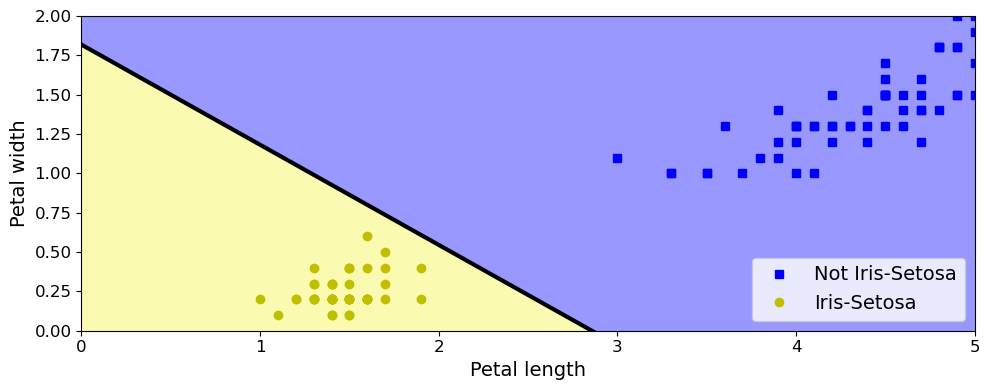

In [6]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

A MLP is composed of one (passthrough) input layer, one or more layers of TLUs, called hidden layers, and one final layer of TLUs called the output layer. The ***backpropagation algorithm*** is used to train MLPs. It is Gradient Descent using an efficient technique for computing the gradients automatically: in just two passes through the network (one forward, one backward), the backpropagation algorithm is able to compute the gradient of the network's error with regard to every single model parameter. In other words, it can find out how each connection weight and each bias term should be tweaked in order to reduce the error. Once it has these gradients, it performs a Gradient Descent step and computes the next batch of gradients, and so on, until it converges to the minimum. 

The backpropagation algorithm works by going through each mini-batch at a time and running the network forward and backward: for each instance in the mini-batch, it makes a prediction (forward pass), measures the error, then goes through each layer in reverse to measure the contribution that each connection made to the error (reverse pass). It then tweaks the connection weights in the direction that reduces the error (Gradiant Descent step).

The backpropagation algorithm uses the ***step*** function, that invlove `logistic functions`: $\sigma(z) = \frac{1}{1 + exp(-z)}$, while logistic function has a well-defined nonzero derivative everywhere, allowing Gradient Descent to make some progress at every step.

The backpropagation algorithm works well with many activation functions (besides logistic function):
- Hyperbolic tangent function: $\text{tanh}(z) = 2\sigma(2z)-1$ <br> it is continuous and differentiable everywhere, and its output value ranges from -1 to 1 (instead of 0 to 1 in the case of the logistic function).
- Rectified Linear Unit function: $\text{ReLU}(z) = \max(0, z)$ <br> it is continuous but unfortunately not differentiable at z = 0 (the slope changes abruptly, which can make Gradient Descent bounce around), and its derivative is 0 for z < 0.   




# Activation functions

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


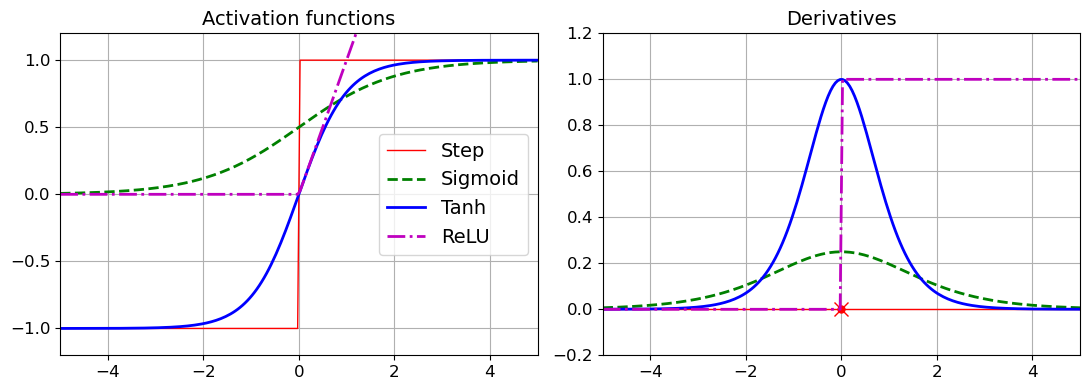

In [8]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

***Q - Why do we need activation functions in the first place?*** <br>
A - Well, if you chain several linear transformations, all you get is a linear transformation. For
example, say f(x) = 2 x + 3 and g(x) = 5 x - 1, then chaining these two linear functions
gives you another linear function: f(g(x)) = 2(5 x - 1) + 3 = 10 x + 1. So if you don’t
have some non-linearity between layers, then even a deep stack of layers is equivalent
to a single layer: you cannot solve very complex problems with that.

In [9]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

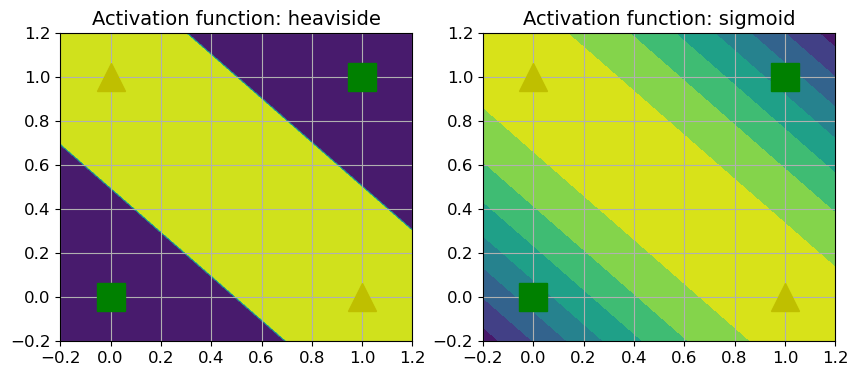

In [10]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [11]:
import tensorflow as tf
from tensorflow import keras

In [12]:
tf.__version__

'2.12.0'

In [13]:
keras.__version__

'2.12.0'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [14]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


The training set contains 60,000 grayscale images, each 28x28 pixels:

In [15]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [16]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [17]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

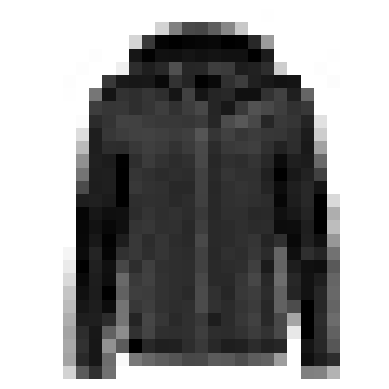

In [18]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [19]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [20]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [21]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [22]:
X_valid.shape

(5000, 28, 28)

In [23]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


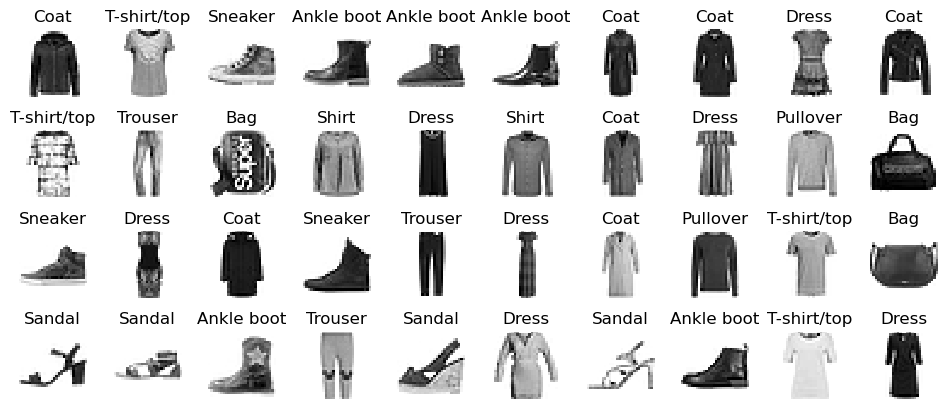

In [24]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

Now let’s build the neural network! Here is a classification MLP with two hidden layers:

In [25]:
model = keras.models.Sequential()                        # This is a sequential model (stack of layers) - the simplest kind of Keras model, for neural networks that are just composed of a single stack of layers
model.add(keras.layers.Flatten(input_shape=[28, 28]))    # This is the first layer (Flatten) with 784 neurons (28*28) - it will convert each input image into a 1D array. Since it is the first layer in the model, you should specify the input_shape: this does not include the batch size, only the shape of the instances.
model.add(keras.layers.Dense(300, activation="relu"))    # This is the second layer (Dense) with 300 neurons - It will use the ReLU activation function.
model.add(keras.layers.Dense(100, activation="relu"))    # This is the third layer (Dense) with 100 neurons - It will also use the ReLU activation function.
model.add(keras.layers.Dense(10, activation="softmax"))  # This is the fourth layer (Dense) with 10 neurons - It will use the softmax activation function (because the classes are exclusive).

In [26]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Specifying `activation="relu"` is equivalent to `activation=keras.activations.relu.` Other activation functions are
available in the keras.activations package, we will use many of
them in this book. See https://keras.io/activations/ for the full list.

In [27]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [28]:
model.layers

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


The model’s summary() method displays all the model’s layers13, including each layer’s
name (which is automatically generated unless you set it when creating the layer), its
output shape (None means the batch size can be anything), and its number of parameters.
The summary ends with the total number of parameters, including trainable and
non-trainable parameters. Here we only have trainable parameters

In [30]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [31]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [32]:
model.get_layer(hidden1.name) is hidden1

True

In [33]:
weights, biases = hidden1.get_weights()

In [34]:
weights

array([[-0.05625424, -0.0150121 ,  0.04423893, ..., -0.04072196,
         0.04381435,  0.03452872],
       [ 0.03956932, -0.03258494, -0.00177027, ...,  0.00702091,
         0.06041591, -0.01875008],
       [-0.07077217, -0.05604509, -0.04586619, ..., -0.04761596,
        -0.01140234, -0.02613552],
       ...,
       [-0.03740522, -0.04110748,  0.0310128 , ...,  0.02906897,
        -0.01160631, -0.038642  ],
       [ 0.03539566,  0.02726629,  0.02241944, ..., -0.0312    ,
         0.02873463, -0.03920265],
       [ 0.04409826, -0.00784802,  0.04366309, ...,  0.04073053,
        -0.01757662,  0.05130495]], dtype=float32)

In [35]:
weights.shape

(784, 300)

In [36]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [37]:
biases.shape

(300,)

In [38]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [39]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7106 - accuracy: 0.7677 - val_loss: 0.5164 - val_accuracy: 0.8256
Epoch 2/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4855 - accuracy: 0.8305 - val_loss: 0.4343 - val_accuracy: 0.8530
Epoch 3/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4410 - accuracy: 0.8449 - val_loss: 0.4960 - val_accuracy: 0.8146
Epoch 4/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4151 - accuracy: 0.8555 - val_loss: 0.3949 - val_accuracy: 0.8656
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3963 - accuracy: 0.8609 - val_loss: 0.3768 - val_accuracy: 0.8670
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3780 - accuracy: 0.8674 - val_loss: 0.3743 - val_accuracy: 0.8696
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3657 - accuracy: 0.8712 - val_loss: 0.3633 - val_accuracy:

In [40]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [41]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [42]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


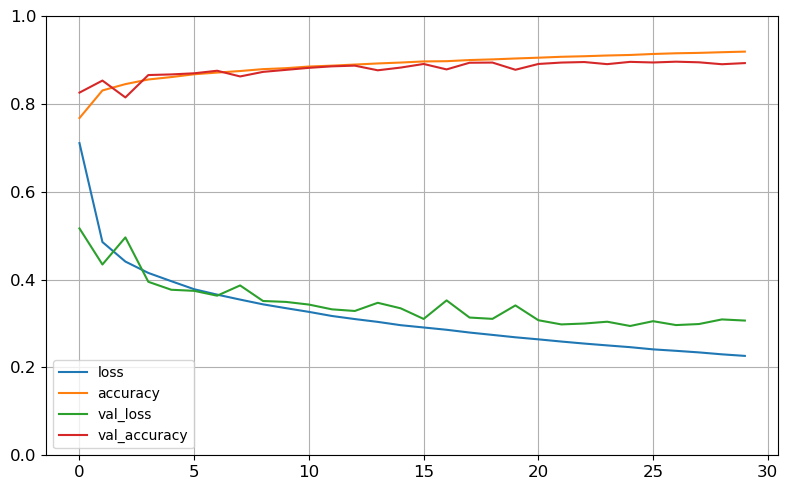

In [43]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

You can see that both the training and validation accuracy steadily increase during
training, while the training and validation loss decrease. Good! Moreover, the validation
curves are quite close to the training curves, which means that there is not too
much overfitting. In this particular case, the model performed better on the validation
set than on the training set at the beginning of training: this sometimes happens
by chance (especially when the validation set is fairly small). However, the training set
performance ends up beating the validation performance, as is generally the case
when you train for long enough. You can tell that the model has not quite converged
yet, as the validation loss is still going down, so you should probably continue training.
It’s as simple as calling the fit() method again, since Keras just continues training
where it left off (you should be able to reach close to 89% validation accuracy).

In [44]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3415 - accuracy: 0.8801


[0.34152546525001526, 0.8801000118255615]

In [46]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 17ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.95],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

**Warning**: `model.predict_classes(X_new)` is deprecated. It is replaced with `np.argmax(model.predict(X_new), axis=-1)`.

In [47]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 [==============================] - 0s 17ms/step


array([9, 2, 1], dtype=int64)

In [48]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [49]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


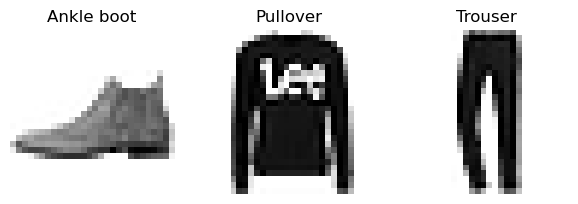

In [50]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [51]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [52]:
np.random.seed(42)
tf.random.set_seed(42)

Building, training, evaluating and using a regression MLP using the Sequential API to
make predictions is quite similar to what we did for classification. The main differences
are the fact that the output layer has a single neuron (since we only want to
predict a single value) and uses no activation function, and the loss function is the
mean squared error. Since the dataset is quite noisy, we just use a single hidden layer
with fewer neurons than before, to avoid overfitting:

In [53]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 2.1015 - val_loss: 1.2407
Epoch 2/20
363/363 [==============================] - 0s 997us/step - loss: 0.8118 - val_loss: 0.7072
Epoch 3/20
363/363 [==============================] - 0s 995us/step - loss: 0.7003 - val_loss: 0.6865
Epoch 4/20
363/363 [==============================] - 0s 963us/step - loss: 0.6563 - val_loss: 0.6152
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6238 - val_loss: 0.5795
Epoch 6/20
363/363 [==============================] - 0s 980us/step - loss: 0.5960 - val_loss: 0.5554
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5726 - val_loss: 0.5361
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5521 - val_loss: 0.5142
Epoch 9/20
363/363 [==============================] - 0s 968us/step - loss: 0.5337 - val_loss: 0.4967
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5178 - val_lo

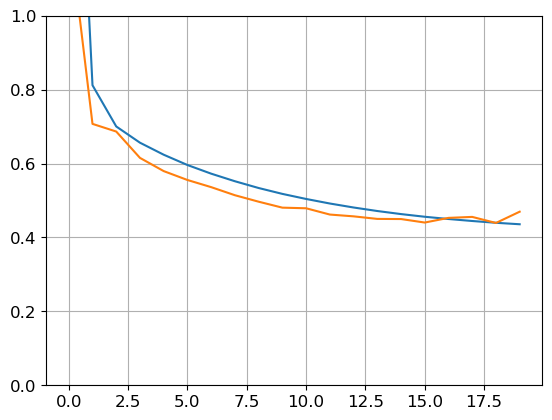

In [54]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [55]:
y_pred

array([[0.6711885],
       [1.7230772],
       [3.2835352]], dtype=float32)

# Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [56]:
np.random.seed(42)
tf.random.set_seed(42)

Let’s build such a neural network to tackle the California housing problem:

In [57]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)     # The first hidden layer is a normal dense layer. It uses the ReLU activation function.
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)    # The second hidden layer is also a dense layer with 30 neurons, using the ReLU activation function.
concat = keras.layers.concatenate([input_, hidden2])            # Then we concatenate the input and the output of the second hidden layer.
output = keras.layers.Dense(1)(concat)                          # The output layer is a dense layer with a single neuron, using no activation function.
model = keras.models.Model(inputs=[input_], outputs=[output])   # Finally, we create a Keras Model, specifying which inputs and outputs to use.

In [58]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 30)           270         ['input_1[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 30)           930         ['dense_5[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 38)           0           ['input_1[0][0]',                
                                                                  'dense_6[0][0]']            

In [59]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20


363/363 [==============================] - 1s 1ms/step - loss: 1.6967 - val_loss: 1.0249
Epoch 2/20
363/363 [==============================] - 0s 934us/step - loss: 0.7522 - val_loss: 0.8269
Epoch 3/20
363/363 [==============================] - 0s 979us/step - loss: 0.6710 - val_loss: 0.6270
Epoch 4/20
363/363 [==============================] - 0s 966us/step - loss: 0.6282 - val_loss: 0.6588
Epoch 5/20
363/363 [==============================] - 0s 928us/step - loss: 0.5964 - val_loss: 0.5862
Epoch 6/20
363/363 [==============================] - 0s 945us/step - loss: 0.5695 - val_loss: 0.5294
Epoch 7/20
363/363 [==============================] - 0s 941us/step - loss: 0.5496 - val_loss: 0.5108
Epoch 8/20
363/363 [==============================] - 0s 990us/step - loss: 0.5328 - val_loss: 0.5364
Epoch 9/20
363/363 [==============================] - 0s 971us/step - loss: 0.5170 - val_loss: 0.4816
Epoch 10/20
363/363 [==============================] - 0s 916us/step - loss: 0.5044 - val_loss:

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

This is how you can build such a model using the Functional API. You just need to specify the inputs. For each hidden layer, you specify which inputs it should use and which activation function it should use, and so on – this is why it is called the Functional API. The feature that goes through wide path is the first 5 features, and the feature that goes through deep path is the last 6 features.

- Wide path: Means that the input features are connected directly to the output layer. This gives the neural network the ability to learn both deep patterns (using the deep path) and simple rules (through the short path). 
- Deep path: Means that the input features are processed by a deep stack of layers before reaching the output layer.


In [60]:
np.random.seed(42)
tf.random.set_seed(42)

In [61]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [62]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20


363/363 [==============================] - 1s 1ms/step - loss: 1.6844 - val_loss: 2.8254
Epoch 2/20
363/363 [==============================] - 0s 966us/step - loss: 0.7553 - val_loss: 0.7342
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6497 - val_loss: 0.6202
Epoch 4/20
363/363 [==============================] - 0s 954us/step - loss: 0.5949 - val_loss: 0.5669
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5566 - val_loss: 0.5286
Epoch 6/20
363/363 [==============================] - 0s 999us/step - loss: 0.5293 - val_loss: 0.5023
Epoch 7/20
363/363 [==============================] - 0s 997us/step - loss: 0.5099 - val_loss: 0.4806
Epoch 8/20
363/363 [==============================] - 0s 996us/step - loss: 0.4948 - val_loss: 0.4679
Epoch 9/20
363/363 [==============================] - 0s 958us/step - loss: 0.4827 - val_loss: 0.4578
Epoch 10/20
363/363 [==============================] - 0s 953us/step - loss: 0.4729 - val_loss: 0.4

Adding an auxiliary output for regularization:

In [63]:
np.random.seed(42)
tf.random.set_seed(42)

In [64]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [65]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [66]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20


363/363 [==============================] - 1s 1ms/step - loss: 2.1758 - main_output_loss: 1.9146 - aux_output_loss: 4.5262 - val_loss: 2.2443 - val_main_output_loss: 0.7885 - val_aux_output_loss: 15.3467
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.9210 - main_output_loss: 0.7162 - aux_output_loss: 2.7643 - val_loss: 2.1141 - val_main_output_loss: 0.7434 - val_aux_output_loss: 14.4499
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7617 - main_output_loss: 0.6307 - aux_output_loss: 1.9408 - val_loss: 1.7409 - val_main_output_loss: 0.5720 - val_aux_output_loss: 12.2617
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6682 - main_output_loss: 0.5709 - aux_output_loss: 1.5440 - val_loss: 1.4393 - val_main_output_loss: 0.5269 - val_aux_output_loss: 9.6513
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6117 - main_output_loss: 0.5326 - aux_output_loss: 1.3241 - val_loss: 1.1809

In [64]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 [==============================] - 0s 546us/step - loss: 0.4668 - main_output_loss: 0.4178 - aux_output_loss: 0.9082


# The subclassing API

In [65]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [66]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 3.3855 - output_1_loss: 3.3304 - output_2_loss: 3.8821 - val_loss: 2.1435 - val_output_1_loss: 1.1581 - val_output_2_loss: 11.0117
Epoch 2/10
363/363 [==============================] - 0s 852us/step - loss: 1.0790 - output_1_loss: 0.9329 - output_2_loss: 2.3942 - val_loss: 1.7567 - val_output_1_loss: 0.8205 - val_output_2_loss: 10.1825
Epoch 3/10
363/363 [==============================] - 0s 885us/step - loss: 0.8644 - output_1_loss: 0.7583 - output_2_loss: 1.8194 - val_loss: 1.5664 - val_output_1_loss: 0.7913 - val_output_2_loss: 8.5419
Epoch 4/10
363/363 [==============================] - 0s 863us/step - loss: 0.7850 - output_1_loss: 0.6979 - output_2_loss: 1.5689 - val_loss: 1.3088 - val_output_1_loss: 0.6549 - val_output_2_loss: 7.1933
Epoch 5/10
363/363 [==============================] - 0s 843us/step - loss: 0.7294 - output_1_loss: 0.6499 - output_2_loss: 1.4452 - val_loss: 1.1357 - val_output_1_loss: 0.596

# Saving and Restoring

In [68]:
np.random.seed(42)
tf.random.set_seed(42)

In [69]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [70]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 882us/step - loss: 3.3697 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 646us/step - loss: 0.6964 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 658us/step - loss: 0.6167 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 653us/step - loss: 0.5846 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 649us/step - loss: 0.5321 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 664us/step - loss: 0.5083 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 677us/step - loss: 0.5044 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 649us/step - loss: 0.4813 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 676us/step - loss: 0.4627 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 497us/step - loss: 0.438

In [71]:
model.save("my_keras_model.h5")

In [72]:
model = keras.models.load_model("my_keras_model.h5")

In [73]:
model.predict(X_new)

array([[0.5400236],
       [1.6505969],
       [3.0098243]], dtype=float32)

In [74]:
model.save_weights("my_keras_weights.ckpt")

In [75]:
model.load_weights("my_keras_weights.ckpt")

# Using Callbacks during Training

In [76]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [77]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [78]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 846us/step - loss: 3.3697 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 672us/step - loss: 0.6964 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 658us/step - loss: 0.6167 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 651us/step - loss: 0.5846 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 670us/step - loss: 0.5321 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 658us/step - loss: 0.5083 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 682us/step - loss: 0.5044 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 657us/step - loss: 0.4813 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 672us/step - loss: 0.4627 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 460us/step - loss: 0.438

In [79]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 0s 878us/step - loss: 0.4578 - val_loss: 0.4110
Epoch 2/100
363/363 [==============================] - 0s 702us/step - loss: 0.4430 - val_loss: 0.4266
Epoch 3/100
363/363 [==============================] - 0s 676us/step - loss: 0.4376 - val_loss: 0.3996
Epoch 4/100
363/363 [==============================] - 0s 671us/step - loss: 0.4361 - val_loss: 0.3939
Epoch 5/100
363/363 [==============================] - 0s 674us/step - loss: 0.4204 - val_loss: 0.3889
Epoch 6/100
363/363 [==============================] - 0s 672us/step - loss: 0.4112 - val_loss: 0.3866
Epoch 7/100
363/363 [==============================] - 0s 671us/step - loss: 0.4226 - val_loss: 0.3860
Epoch 8/100
363/363 [==============================] - 0s 659us/step - loss: 0.4135 - val_loss: 0.3793
Epoch 9/100
363/363 [==============================] - 0s 661us/step - loss: 0.4039 - val_loss: 0.3746
Epoch 10/100
363/363 [==============================] - 0s 655us/step - l

In [80]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [81]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

363/363 [==============================] - 0s 799us/step - loss: 0.3302 - val_loss: 0.3556

val/train: 1.08


# TensorBoard

In [82]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [83]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2021_02_13-18_39_20'

In [84]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [85]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [86]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 927us/step - loss: 3.3697 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 0s 695us/step - loss: 0.6964 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 0s 668us/step - loss: 0.6167 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 0s 672us/step - loss: 0.5846 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 0s 692us/step - loss: 0.5321 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 0s 755us/step - loss: 0.5083 - val_loss: 0.4951
Epoch 7/30
363/363 [==============================] - 0s 697us/step - loss: 0.5044 - val_loss: 0.4861
Epoch 8/30
363/363 [==============================] - 0s 668us/step - loss: 0.4813 - val_loss: 0.4554
Epoch 9/30
363/363 [==============================] - 0s 681us/step - loss: 0.4627 - val_loss: 0.4413
Epoch 10/30
363/363 [==============================] - 0s 701us/step - loss: 0.454

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [87]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

In [88]:
run_logdir2 = get_run_logdir()
run_logdir2

'./my_logs/run_2021_02_13-18_39_31'

In [89]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [90]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.05))

In [91]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 1ms/step - loss: 0.7645 - val_loss: 302.8536
Epoch 2/30
363/363 [==============================] - 0s 713us/step - loss: 8159520618.2209 - val_loss: 1.3230
Epoch 3/30
363/363 [==============================] - 0s 735us/step - loss: 1.3439 - val_loss: 1.3176
Epoch 4/30
363/363 [==============================] - 0s 738us/step - loss: 1.3546 - val_loss: 1.3261
Epoch 5/30
363/363 [==============================] - 0s 712us/step - loss: 1.3513 - val_loss: 1.3154
Epoch 6/30
363/363 [==============================] - 0s 724us/step - loss: 1.3274 - val_loss: 1.3203
Epoch 7/30
363/363 [==============================] - 0s 693us/step - loss: 1.3639 - val_loss: 1.3149
Epoch 8/30
363/363 [==============================] - 0s 709us/step - loss: 1.3487 - val_loss: 1.3157
Epoch 9/30
363/363 [==============================] - 0s 681us/step - loss: 1.3445 - val_loss: 1.3150
Epoch 10/30
363/363 [==============================] - 0s 681us/step - lo

Notice how TensorBoard now sees two runs, and you can compare the learning curves.

Check out the other available logging options:

In [92]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# Hyperparameter Tuning

In [93]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [94]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [95]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [96]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 0s 905us/step - loss: 1.5673 - val_loss: 20.7721
Epoch 2/100
363/363 [==============================] - 0s 665us/step - loss: 1.3216 - val_loss: 5.0266
Epoch 3/100
363/363 [==============================] - 0s 671us/step - loss: 0.5972 - val_loss: 0.5490
Epoch 4/100
363/363 [==============================] - 0s 661us/step - loss: 0.4985 - val_loss: 0.4529
Epoch 5/100
363/363 [==============================] - 0s 687us/step - loss: 0.4608 - val_loss: 0.4188
Epoch 6/100
363/363 [==============================] - 0s 678us/step - loss: 0.4410 - val_loss: 0.4129
Epoch 7/100
363/363 [==============================] - 0s 676us/step - loss: 0.4463 - val_loss: 0.4004
Epoch 8/100
363/363 [==============================] - 0s 686us/step - loss: 0.4283 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 0s 660us/step - loss: 0.4139 - val_loss: 0.3961
Epoch 10/100
363/363 [==============================] - 0s 681us/step - 

In [97]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 417us/step - loss: 0.3409


In [98]:
y_pred = keras_reg.predict(X_new)

In [99]:
np.random.seed(42)
tf.random.set_seed(42)

**Warning**: the following cell crashes at the end of training. This seems to be caused by [Keras issue #13586](https://github.com/keras-team/keras/issues/13586), which was triggered by a recent change in Scikit-Learn. [Pull Request #13598](https://github.com/keras-team/keras/pull/13598) seems to fix the issue, so this problem should be resolved soon. In the meantime, I've added `.tolist()` and `.rvs(1000).tolist()` as workarounds.

In [100]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100)               .tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2)      .rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3827 - val_loss: 0.4703
Epoch 2/100
242/242 [==============================] - 0s 757us/step - loss: 0.4880 - val_loss: 0.4247
Epoch 3/100
242/242 [==============================] - 0s 765us/step - loss: 0.4541 - val_loss: 0.4052
Epoch 4/100
242/242 [==============================] - 0s 745us/step - loss: 0.4518 - val_loss: 0.3975
Epoch 5/100
242/242 [==============================] - 0s 765us/step - loss: 0.4337 - val_loss: 0.3991
Epoch 6/100
242/242 [==============================] - 0s 751us/step - loss: 0.4263 - val_loss: 0.4031
Epoch 7/100
242/242 [==============================] - 0s 743us/step - loss: 0.4385 - val_loss: 0.4043
Epoch 8/100
242/242 [==============================] - 0s 780us/step - loss: 0.4301 - val_loss: 0.3929
Epoch 9/100
242/242 [==============================] - 0s 792us/step - loss: 0.4108 - val_loss: 0.4040
Epoch 10/100
2

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fd939643c10>,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845322936229,
                                                          0.004779156784872302,
                                                          0.0...
                                                          0.00502142573

In [101]:
rnd_search_cv.best_params_

{'n_neurons': 74, 'n_hidden': 3, 'learning_rate': 0.005803602934201024}

In [102]:
rnd_search_cv.best_score_

-0.32039451599121094

In [103]:
rnd_search_cv.best_estimator_

In [104]:
rnd_search_cv.score(X_test, y_test)

162/162 [==============================] - 0s 436us/step - loss: 0.3029


-0.3028871417045593

In [105]:
model = rnd_search_cv.best_estimator_.model
model

In [106]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 446us/step - loss: 0.3029


0.3028871417045593

# Exercise solutions

## 1. to 9.

See appendix A.

## 10.

*Exercise: Train a deep MLP on the MNIST dataset (you can load it using `keras.datasets.mnist.load_data()`. See if you can get over 98% precision. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.*

Let's load the dataset:

In [107]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [108]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is also represented as a byte (0 to 255):

In [109]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [110]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

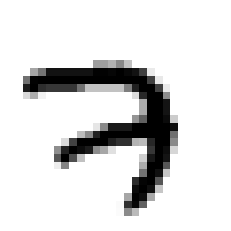

In [111]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a `class_names` array:

In [112]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [113]:
X_valid.shape

(5000, 28, 28)

In [114]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

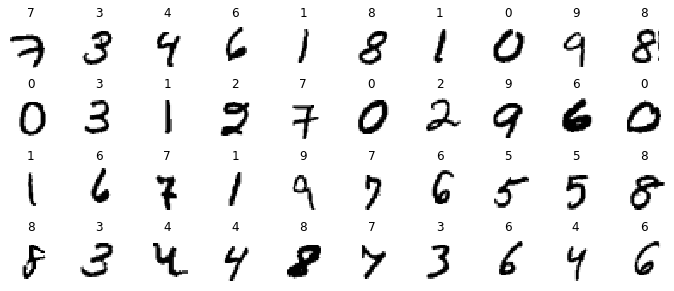

In [115]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [116]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [117]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [118]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [119]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch:

In [120]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 2s 1ms/step - loss: 4.6604 - accuracy: 0.4887 - val_loss: 2.3911 - val_accuracy: 0.1126


We can now plot the loss as a function of the learning rate:

Text(0, 0.5, 'Loss')

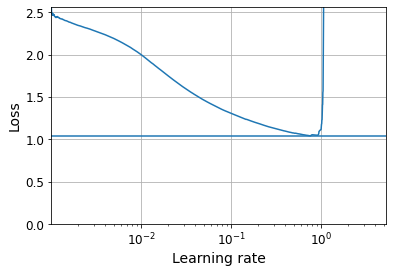

In [121]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently when the learning rate goes over 6e-1, so let's try using half of that, at 3e-1:

In [122]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [123]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [124]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=3e-1),
              metrics=["accuracy"])

In [125]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'./my_mnist_logs/run_001'

In [126]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4195 - accuracy: 0.8677 - val_loss: 0.0995 - val_accuracy: 0.9724
Epoch 2/100
1719/1719 [==============================] - 2s 882us/step - loss: 0.0941 - accuracy: 0.9698 - val_loss: 0.0913 - val_accuracy: 0.9746
Epoch 3/100
1719/1719 [==============================] - 1s 845us/step - loss: 0.0650 - accuracy: 0.9792 - val_loss: 0.0785 - val_accuracy: 0.9772
Epoch 4/100
1719/1719 [==============================] - 2s 932us/step - loss: 0.0438 - accuracy: 0.9855 - val_loss: 0.0793 - val_accuracy: 0.9784
Epoch 5/100
1719/1719 [==============================] - 1s 832us/step - loss: 0.0348 - accuracy: 0.9888 - val_loss: 0.0724 - val_accuracy: 0.9812
Epoch 6/100
1719/1719 [==============================] - 1s 835us/step - loss: 0.0289 - accuracy: 0.9905 - val_loss: 0.0814 - val_accuracy: 0.9792
Epoch 7/100
1719/1719 [==============================] - 1s 868us/step - loss: 0.0230 - accuracy: 0.9926 - val_loss: 0.0

In [127]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 701us/step - loss: 0.0804 - accuracy: 0.9806


[0.08043695986270905, 0.9805999994277954]

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [128]:
%tensorboard --logdir=./my_mnist_logs --port=6006